In [1]:
# Import the torch library
import os
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torch
import torch.nn.functional as F
import cv2
from tqdm.auto import tqdm
import pandas as pd

In [2]:
dataset_path = 'ImageToImage/test_samples'

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

class ImageTranslationDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.rgb_images = os.listdir(os.path.join(root, 'rgb'))
        self.thermal_images = os.listdir(os.path.join(root, 'thermal'))

    def __len__(self):
        return min(len(self.rgb_images), len(self.thermal_images))

    def __getitem__(self, idx):
        rgb_img_name = os.path.join(self.root, 'rgb', self.rgb_images[idx])
        thermal_img_name = os.path.join(self.root, 'thermal', self.rgb_images[idx])  # Assumes filenames match

        rgb_image = Image.open(rgb_img_name)
        thermal_image = Image.open(thermal_img_name)

        if self.transform:
            rgb_image = self.transform(rgb_image)
            thermal_image = self.transform(thermal_image)

        return rgb_image, thermal_image

In [5]:
# Create data loader
batch_size = 16
dataset = ImageTranslationDataset(dataset_path, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [6]:
# Define the Generator model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Define the architecture for the generator
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1),
        nn.Tanh()
        )

    def forward(self, x):
        # Implement the forward pass of the generator
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Define the Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Define the architecture for the discriminator
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Implement the forward pass of the discriminator
        out = self.model(x)
        return out

# Create instances of the Generator and Discriminator
generator = Generator()
discriminator = Discriminator()

In [13]:
# Directory to save model checkpoints
model_checkpoint_directory = 'Model2'
os.makedirs(model_checkpoint_directory, exist_ok=True)

# Define the loss function 
criterion = nn.MSELoss()

# Define the learning rate and create optimizers for the generator and discriminator
lr = 0.0002
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

In [14]:
# Define the number of training epochs
num_epochs = 20

# Training loop
for epoch in range(num_epochs):
    for i, (real_rgb, real_thermal) in enumerate(data_loader):
        # Check if GPU is available, otherwise use CPU
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # move tensors to the device
        real_rgb = real_rgb.to(device)
        real_thermal = real_thermal.to(device)

        # Training the discriminator
        optimizer_D.zero_grad()

        # Forward pass with real thermal images
        output_real = discriminator(real_thermal)
        loss_real = criterion(output_real, torch.ones_like(output_real))

        # Generate fake thermal images with the generator
        fake_thermal = generator(real_rgb)

        # Forward pass with fake thermal images
        output_fake = discriminator(fake_thermal.detach())
        loss_fake = criterion(output_fake, torch.zeros_like(output_fake))

        # Total discriminator loss
        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # Training the generator
        optimizer_G.zero_grad()

        # Generate fake thermal images with the generator
        fake_thermal = generator(real_rgb)

        # Forward pass with fake thermal images
        output_fake = discriminator(fake_thermal)

        # Generator loss
        loss_G = criterion(output_fake, torch.ones_like(output_fake))
        loss_G.backward()
        optimizer_G.step()

        # Print training information
        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Step [{i}/{len(data_loader)}], Loss_D: {loss_D.item():.4f}, Loss_G: {loss_G.item():.4f}')

            # Save the generator and discriminator models every 20 epochs
            if (epoch + 1) % 10 == 0:
                generator_path = os.path.join(model_checkpoint_directory, f'generator_{epoch}.pth')
                discriminator_path = os.path.join(model_checkpoint_directory, f'discriminator_{epoch}.pth')
                torch.save(generator.state_dict(), generator_path)
                torch.save(discriminator.state_dict(), discriminator_path)

Epoch [0/20], Step [9/63], Loss_D: 0.4195, Loss_G: 0.3001
Epoch [0/20], Step [19/63], Loss_D: 0.3146, Loss_G: 0.2913
Epoch [0/20], Step [29/63], Loss_D: 0.3701, Loss_G: 0.1950
Epoch [0/20], Step [39/63], Loss_D: 0.4312, Loss_G: 0.1684
Epoch [0/20], Step [49/63], Loss_D: 0.4687, Loss_G: 0.1721
Epoch [0/20], Step [59/63], Loss_D: 0.4989, Loss_G: 0.2016
Epoch [1/20], Step [9/63], Loss_D: 0.5337, Loss_G: 0.1875
Epoch [1/20], Step [19/63], Loss_D: 0.5354, Loss_G: 0.1730
Epoch [1/20], Step [29/63], Loss_D: 0.4786, Loss_G: 0.2130
Epoch [1/20], Step [39/63], Loss_D: 0.4129, Loss_G: 0.2440
Epoch [1/20], Step [49/63], Loss_D: 0.4124, Loss_G: 0.2613
Epoch [1/20], Step [59/63], Loss_D: 0.4126, Loss_G: 0.2664
Epoch [2/20], Step [9/63], Loss_D: 0.4649, Loss_G: 0.2101
Epoch [2/20], Step [19/63], Loss_D: 0.5709, Loss_G: 0.1300
Epoch [2/20], Step [29/63], Loss_D: 0.4591, Loss_G: 0.1798
Epoch [2/20], Step [39/63], Loss_D: 0.3367, Loss_G: 0.3205
Epoch [2/20], Step [49/63], Loss_D: 0.3996, Loss_G: 0.2650


In [7]:
def psnr(prediction, target, max_val=1.0):
    mse = F.mse_loss(prediction, target)
    psnr = 10 * torch.log10((max_val ** 2) / mse)
    return psnr

In [18]:
# Define the path to the validation dataset 
val_dataset_path = 'ImageToImage/test_samples'

# Define a custom dataset class for validation
class ValidationImageTranslationDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.rgb_images = os.listdir(os.path.join(root, 'rgb'))
        self.thermal_images = os.listdir(os.path.join(root, 'thermal'))

    def __len__(self):
        return min(len(self.rgb_images), len(self.thermal_images))

    def __getitem__(self, idx):
        rgb_img_name = os.path.join(self.root, 'rgb', self.rgb_images[idx])
        thermal_img_name = os.path.join(self.root, 'thermal', self.thermal_images[idx])

        rgb_image = Image.open(rgb_img_name)
        thermal_image = Image.open(thermal_img_name)

        if self.transform:
            rgb_image = self.transform(rgb_image)
            thermal_image = self.transform(thermal_image)

        return rgb_image, thermal_image, os.path.basename(thermal_img_name)  # Include the image filename


# Create a data loader for validation
batch_size = 32
validation_dataset = ValidationImageTranslationDataset(val_dataset_path, transform=transform)
validation_data_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# Load the trained generator model
generator = Generator()  # trained generator model
generator.load_state_dict(torch.load('Model/best_generator_19.pth'))
generator.eval()

# Move the generator model to the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)

# Validation loop
validation_loss = 0.0
total_psnr = 0.0
num_samples = 0

# Create a directory to save the generated thermal images from the validation dataset
gen_val_directory = 'check'
os.makedirs(gen_val_directory, exist_ok=True)

with torch.no_grad():
    for i, (real_rgb, real_thermal, image_filename) in enumerate(validation_data_loader):
        real_rgb = real_rgb.to(device)
        real_thermal = real_thermal.to(device)

        # Generate fake thermal images with the generator
        fake_thermal = generator(real_rgb).cpu()  # Move back to CPU for image saving

        for j in range(fake_thermal.size(0)):
            image = fake_thermal[j].permute(1, 2, 0).numpy()

            # Convert the image values from (-1, 1) to (0, 1)
            image = (image + 1) / 2

            # Save the generated thermal image using the original image filename
            generated_image_filename = os.path.join(gen_val_directory, image_filename[j])
            Image.fromarray((image * 255).astype(np.uint8)).save(generated_image_filename)

        # Calculate the PSNR
        psnr_batch = psnr(real_thermal, fake_thermal)
        total_psnr += psnr_batch.sum().item()

        # Calculate the loss (e.g., MSE) between real thermal and generated thermal
        # validation_loss += criterion(fake_thermal, real_thermal).item()

        num_samples += real_rgb.size(0)

# Calculate the average PSNR and validation loss
average_psnr = total_psnr / num_samples
# average_validation_loss = validation_loss / num_samples

print(f'Average PSNR: {average_psnr:.4f}')
# print(f'Average Validation Loss: {average_validation_loss:.4f}')
print(f'Generated images saved in: {gen_val_directory}')

Average PSNR: 0.7492
Generated images saved in: check


In [19]:
# To convert images to Row-Major Format
def row_major_enc(img):
    lst = []
    H,W,C = img.shape
    for i in range(C):
        for j in range(W):
            for k in range(H):
                lst.append(img[k][j][i])
    return lst
# Creating a submission.csv
BASE = "check" # wherever you save predictions OR if you have a prediction list use it directly)
val_rgb_lst = os.listdir(BASE)
subDict = {"ID":[], "RMImg": []}

for im_name in tqdm(val_rgb_lst):
    img = cv2.imread(os.path.join(BASE, im_name))
    rme_img = row_major_enc(img)

    subDict["ID"].append(im_name)
    subDict["RMImg"].append(rme_img)

subPd = pd.DataFrame({"ID": [x for x in subDict["ID"]],
                      "RMImg": [x for x in subDict["RMImg"]]})

subPd.to_csv("check_test.csv", index=False)

  0%|          | 0/8 [00:00<?, ?it/s]

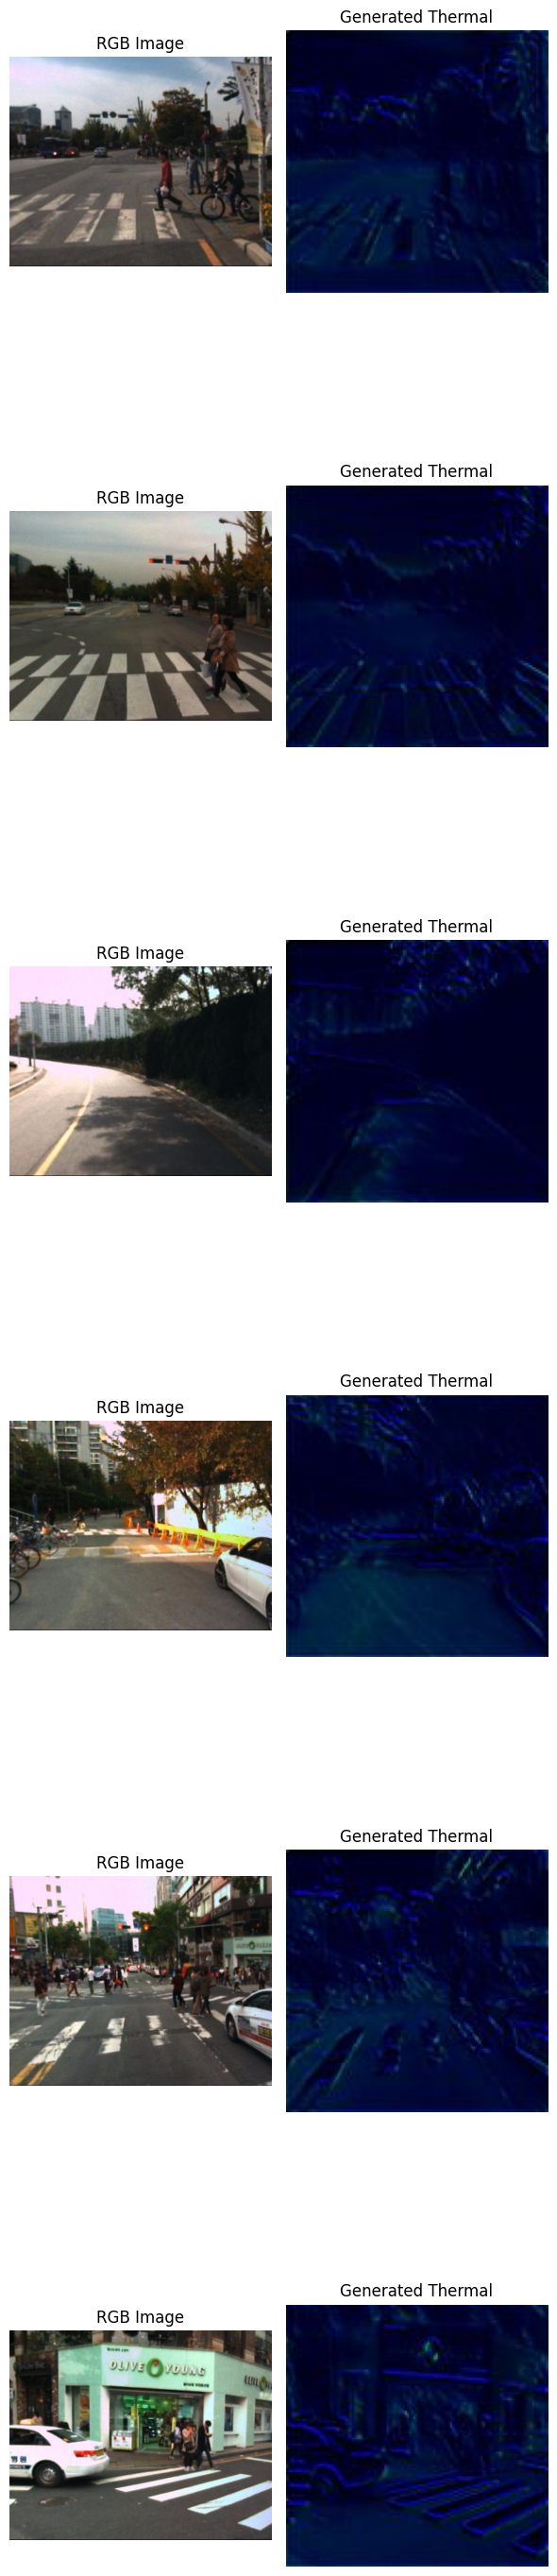

In [20]:
import matplotlib.pyplot as plt
import os
import cv2

# Directories containing your images
rgb_directory = 'test_samples/rgb'  
thermal_directory = 'check'  
# List the files in the directories
rgb_images = os.listdir(rgb_directory)
thermal_images = os.listdir(thermal_directory)

# Take up to 4 pairs for visualization
num_pairs = min(7, min(len(rgb_images), len(thermal_images)))

# Plotting the image pairs
fig, axes = plt.subplots(num_pairs, 2, figsize=(6, num_pairs * 5))

for i in range(num_pairs):
    # Read the images
    rgb_image = cv2.imread(os.path.join(rgb_directory, rgb_images[i]))
    thermal_image = cv2.imread(os.path.join(thermal_directory, thermal_images[i]))

    # Convert BGR to RGB
    rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
    thermal_image = cv2.cvtColor(thermal_image, cv2.COLOR_BGR2RGB)

    # Plot the images
    axes[i, 0].imshow(rgb_image)
    axes[i, 0].set_title('RGB Image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(thermal_image)
    axes[i, 1].set_title('Generated Thermal')
    axes[i, 1].axis('off')
#plt.title('result of test')
plt.tight_layout()
plt.show()